In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

In [2]:
# Number of samples. 
n = 1000
# Generate "time" variable. 
t = np.arange(n)

data_df = pd.DataFrame({'t' : t})

In [3]:
# Generate seasonal variables. 
def seasonal(t, amplitude, period):
    """Generate a sinusoidal curve."""
    y1 = amplitude * np.sin((2*np.pi)*t/period) 
    return y1

# Add two seasonal components. 
data_df['s1'] = data_df['t'].apply(lambda t : seasonal(t, amplitude=2, period=40))

# Define target variable. 
data_df['y1'] = data_df['s1']

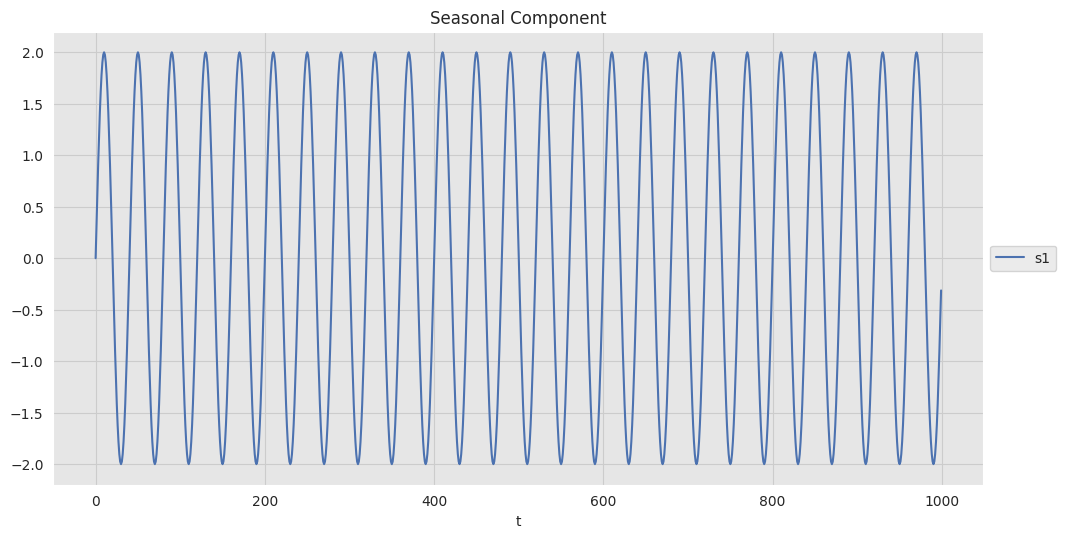

In [4]:
fig, ax = plt.subplots()
sns.lineplot(x='t', y='s1', data=data_df, color=sns_c[0], label='s1', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Seasonal Component', xlabel='t', ylabel='');

In [5]:
# Set noise standard deviation. 
sigma_n = 0.3

data_df['epsilon'] = np.random.normal(loc=0, scale=sigma_n, size=n)
# Add noise to target variable. 
data_df ['y1'] = data_df ['y1'] + data_df ['epsilon']

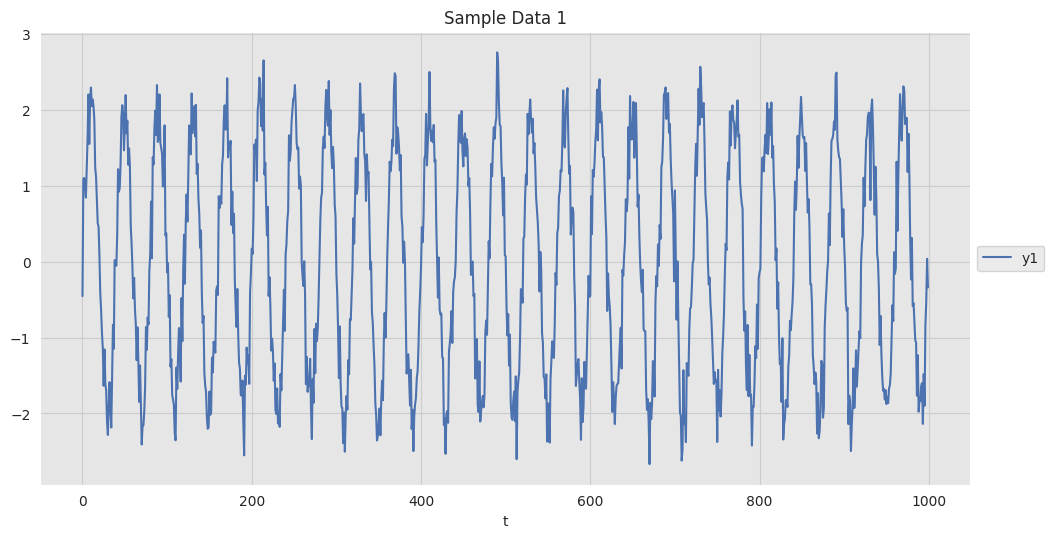

In [6]:
fig, ax = plt.subplots()
sns.lineplot(x='t', y='y1', data=data_df, color=sns_c[0], label='y1', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Sample Data 1', xlabel='t', ylabel='');

In [7]:
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, ConstantKernel, RBF,DotProduct

k0 = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 0.5**2))

k1 = ConstantKernel(constant_value=2) * \
  ExpSineSquared(length_scale=1.0, periodicity=40, periodicity_bounds=(35, 45))

kernel_1  = k0 + k1 

In [8]:
from sklearn.gaussian_process import GaussianProcessRegressor

gp1 = GaussianProcessRegressor(
    kernel=kernel_1, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)

In [9]:
X = data_df['t'].values.reshape(n, 1)
y = data_df['y1'].values.reshape(n, 1)

prop_train = 0.7
n_train = round(prop_train * n)

X_train = X[:n_train]
y_train = y[:n_train]

X_test = X[n_train:]
y_test = y[n_train:]

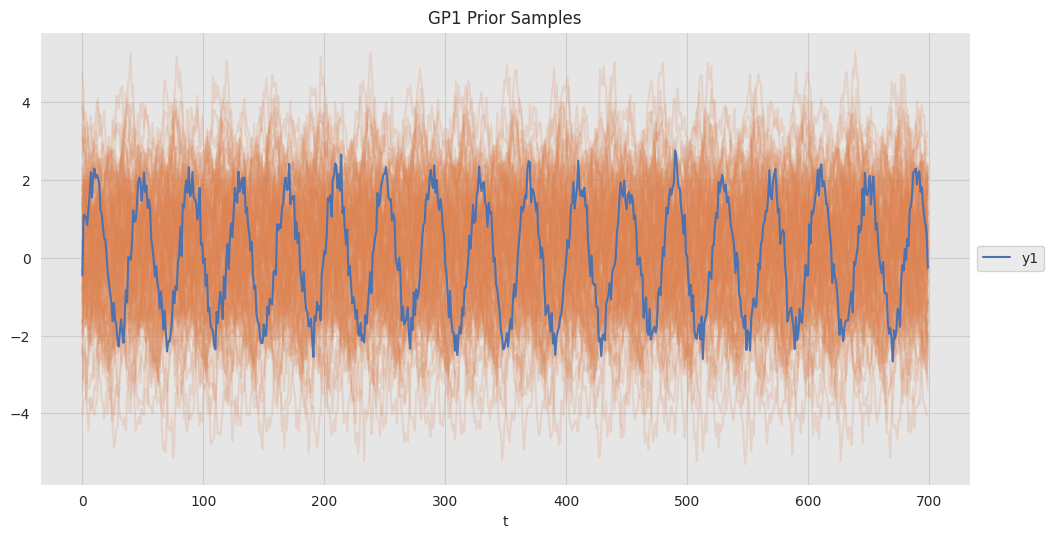

In [10]:
gp1_prior_samples = gp1.sample_y(X=X_train, n_samples=100)

fig, ax = plt.subplots()
for i in range(100):
    sns.lineplot(x=X_train[...,0], y = gp1_prior_samples[:, i], color=sns_c[1], alpha=0.2, ax=ax)
sns.lineplot(x=X_train[...,0], y=y_train[..., 0], color=sns_c[0], label='y1', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='GP1 Prior Samples', xlabel='t');

Vamos dar uma analisada nas prior samples de alguns kernels

In [11]:
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, ConstantKernel, RBF,DotProduct, Matern

rbf_model = GaussianProcessRegressor(kernel = RBF(length_scale = 2))
white_model = GaussianProcessRegressor(kernel = WhiteKernel())
expsine_model = GaussianProcessRegressor(kernel = ExpSineSquared(length_scale=1.0, periodicity=40, periodicity_bounds=(35, 45)))
constant_model = GaussianProcessRegressor(kernel=ConstantKernel())
dot_model = GaussianProcessRegressor(kernel=DotProduct())

models = [rbf_model, white_model, expsine_model, constant_model, dot_model]
models_names = ['RBF', 'White', 'Expsine', 'Constante', 'Dot']

In [12]:
x_samples = np.arange(50).reshape(-1,1)
prior_samples = [model.sample_y(X = x_samples, n_samples = 50) for model in models]

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


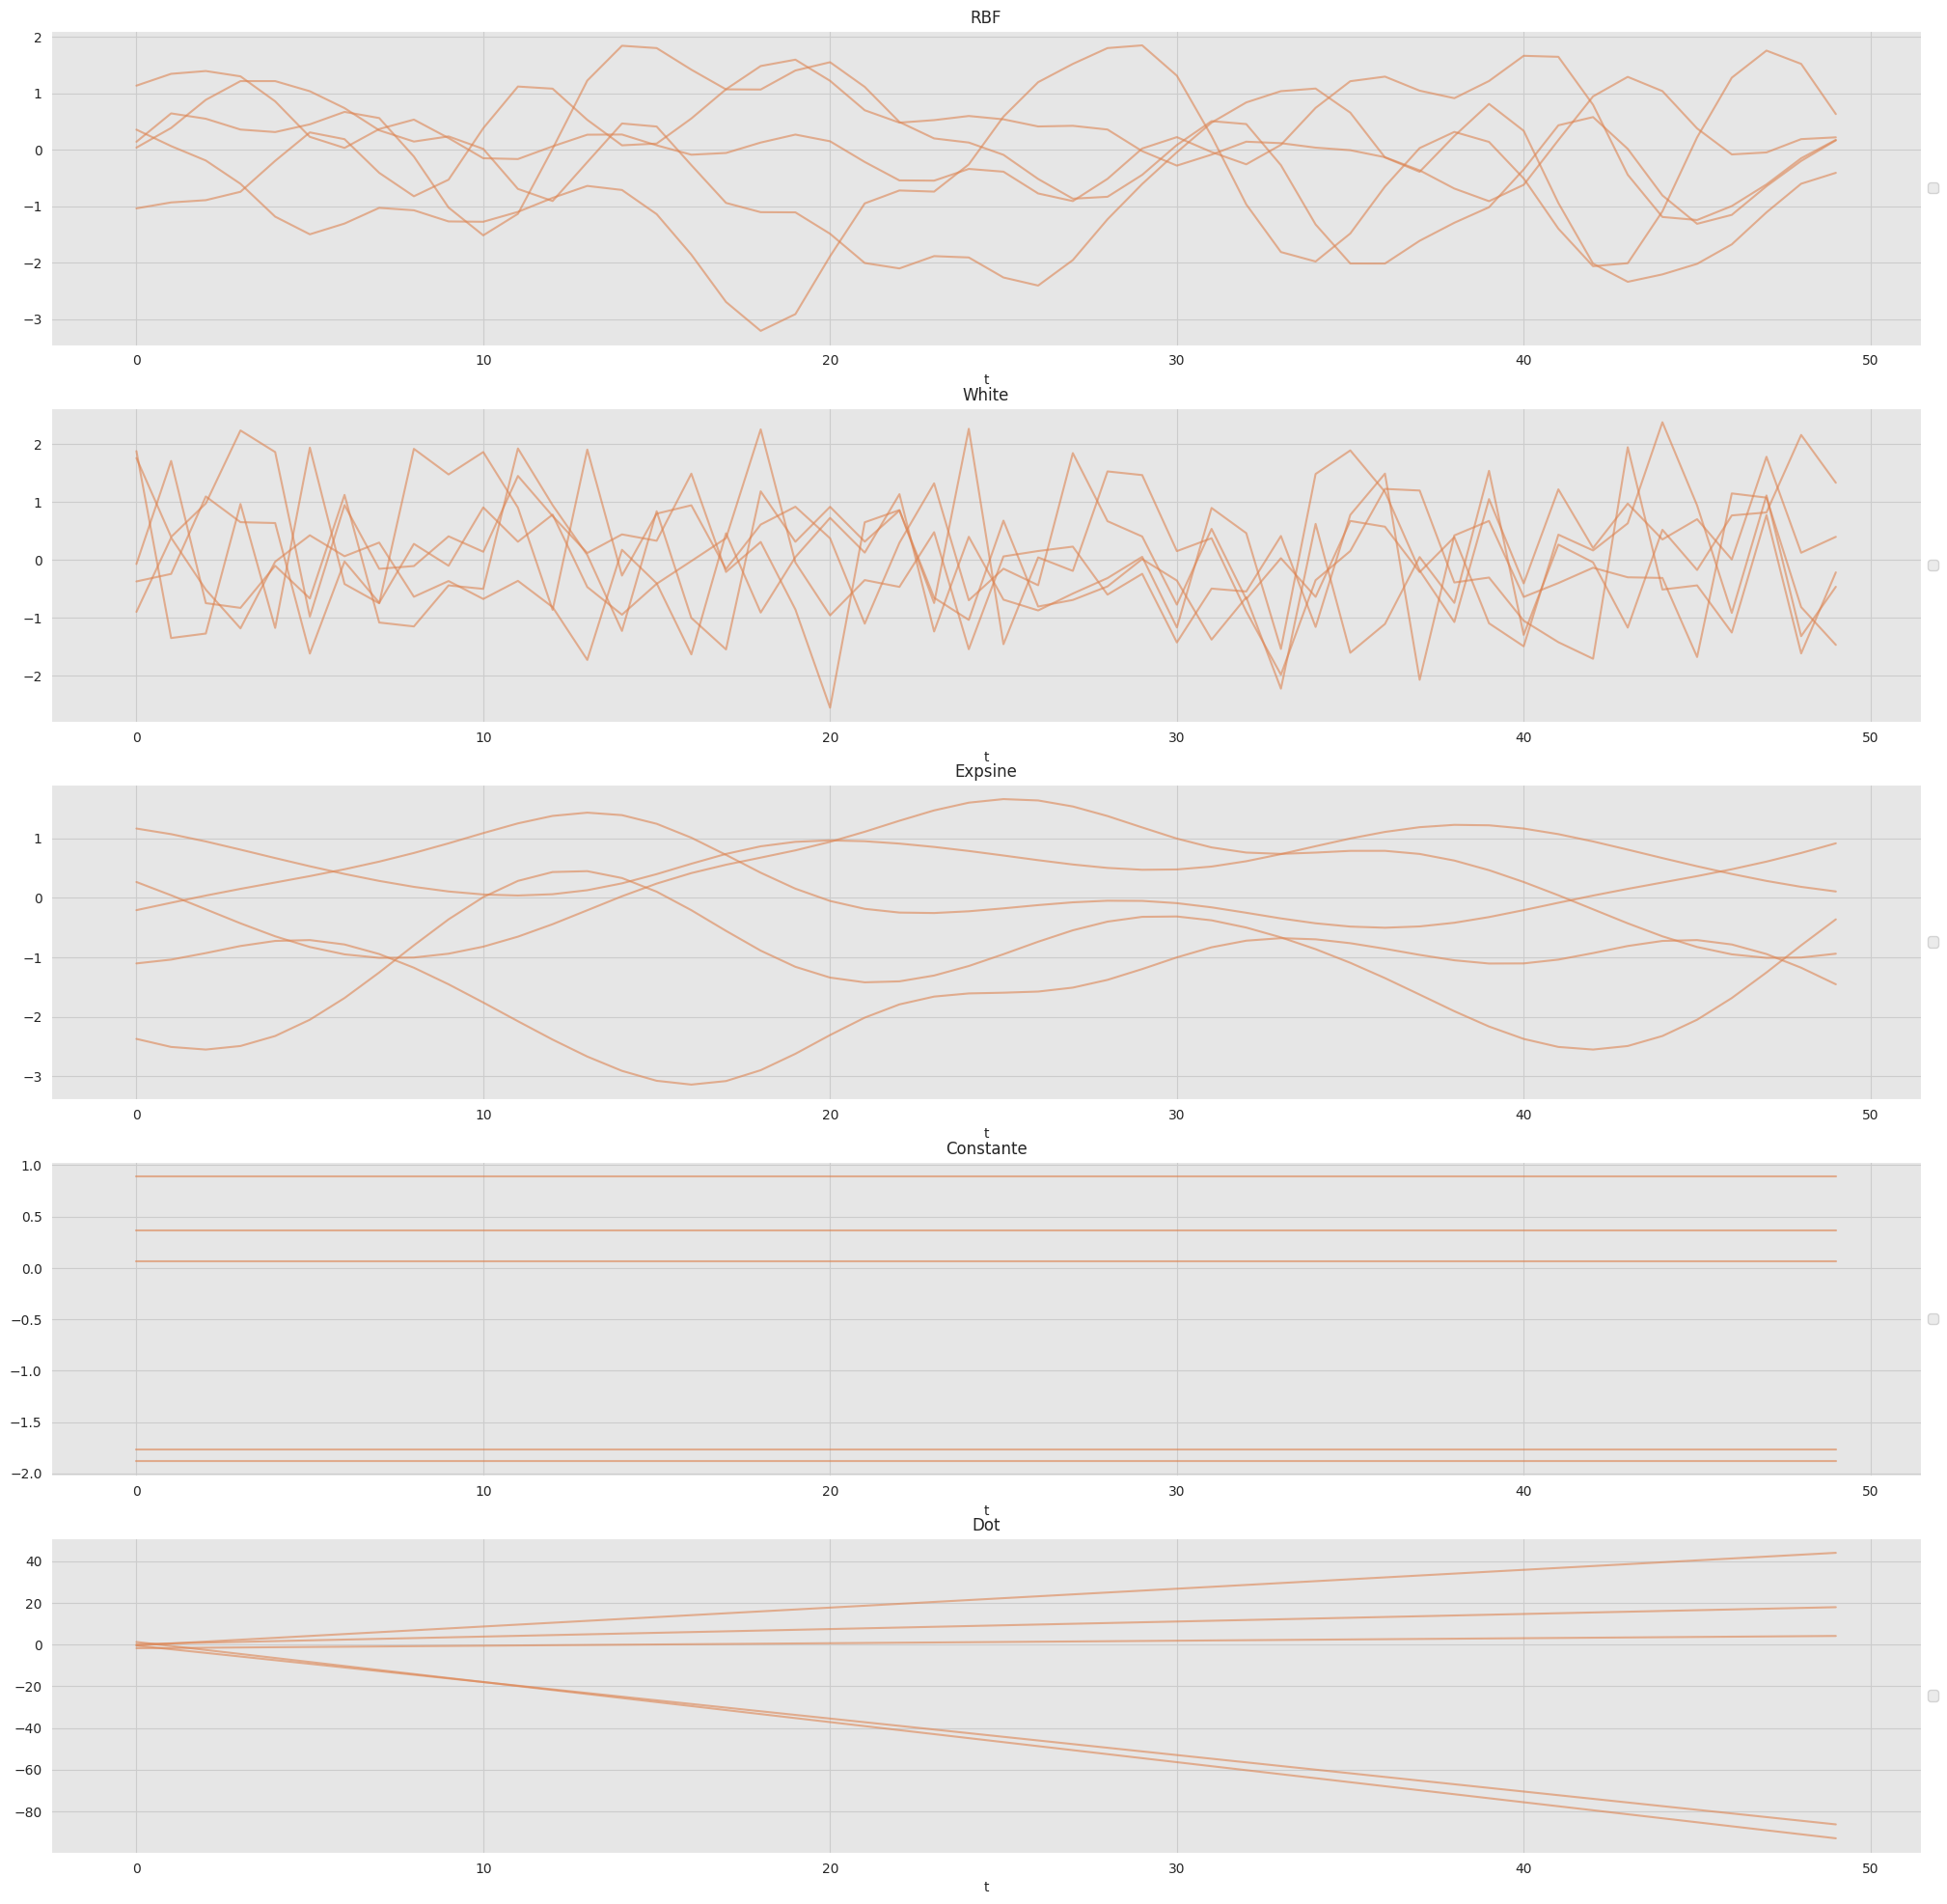

In [13]:

fig, ax = plt.subplots(figsize = (25,25),nrows=5)
for j,prior_sample in enumerate(prior_samples):
    for i in range(5):
        sns.lineplot(x=x_samples[...,0], y = prior_sample[:, i], color=sns_c[1], alpha=0.6, ax=ax[j])


    ax[j].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax[j].set(title=models_names[j], xlabel='t');

# Continuando com o fit e predictions

In [14]:
gp1.fit(X_train, y_train)

GaussianProcessRegressor(alpha=0.0,
                         kernel=WhiteKernel(noise_level=0.09) + 1.41**2 * ExpSineSquared(length_scale=1, periodicity=40),
                         n_restarts_optimizer=10, normalize_y=True)

In [15]:
y_pred, y_std = gp1.predict(X, return_std=True)

data_df['y_pred'] = y_pred
data_df['y_std'] = y_std
data_df['y_pred_lwr'] = data_df['y_pred'] - 2*data_df['y_std']
data_df['y_pred_upr'] = data_df['y_pred'] + 2*data_df['y_std']

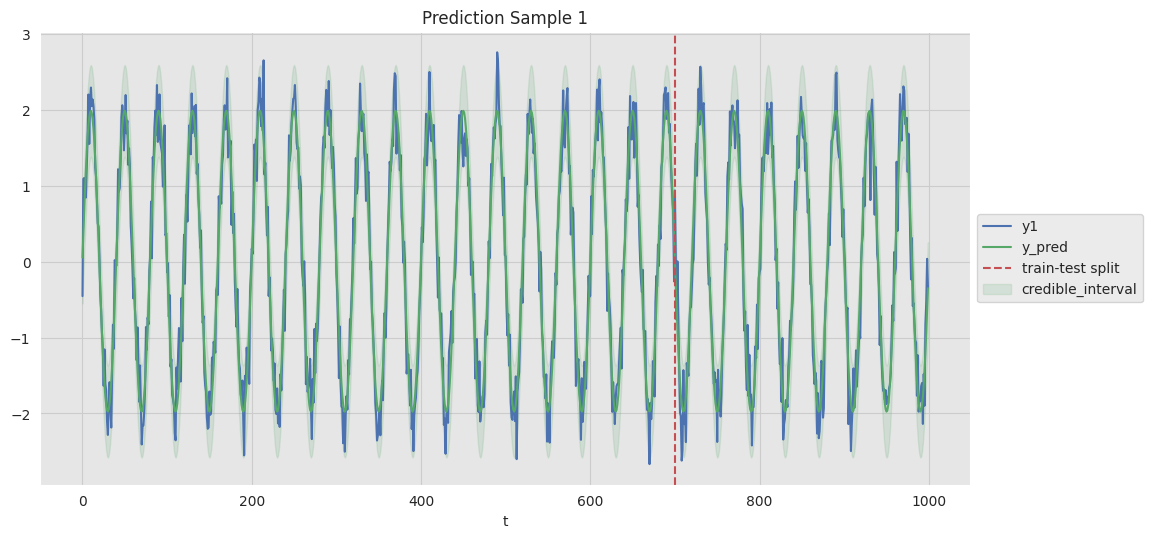

In [16]:
fig, ax = plt.subplots()

ax.fill_between(
    x=data_df['t'], 
    y1=data_df['y_pred_lwr'], 
    y2=data_df['y_pred_upr'], 
    color=sns_c[2], 
    alpha=0.15, 
    label='credible_interval'
)

sns.lineplot(x='t', y='y1', data=data_df, color=sns_c[0], label = 'y1', ax=ax)
sns.lineplot(x='t', y='y_pred', data=data_df, color=sns_c[2], label='y_pred', ax=ax)

ax.axvline(n_train, color=sns_c[3], linestyle='--', label='train-test split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Prediction Sample 1', xlabel='t', ylabel='');

/home/andre/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


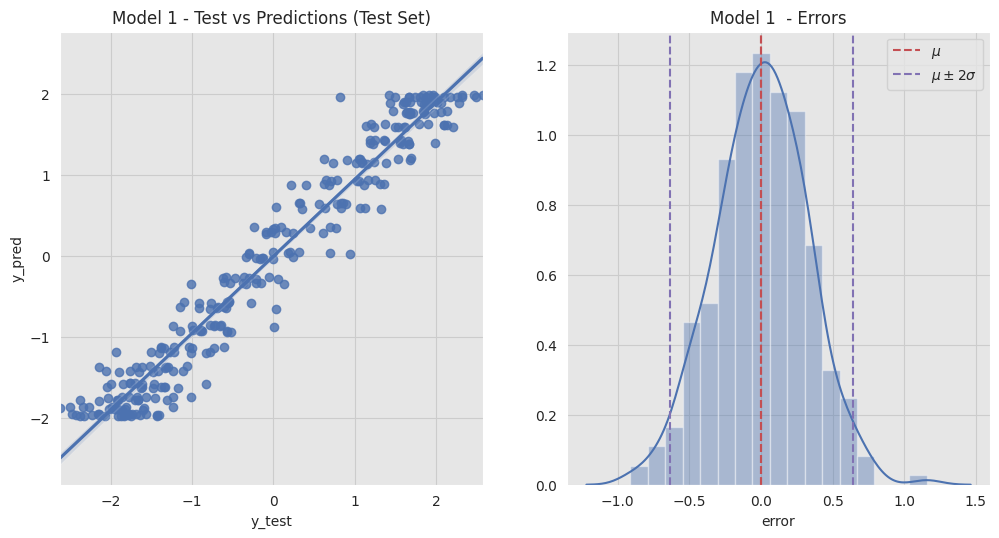

In [17]:
errors = gp1.predict(X_test) - y_test
errors = errors.flatten()
errors_mean = errors.mean()
errors_std = errors.std()

fig, ax = plt.subplots(1, 2, figsize=(12, 6)) 
sns.regplot(x=y_test.flatten(), y=gp1.predict(X_test).flatten(), ax=ax[0])
sns.distplot(a=errors, ax=ax[1])
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--', label=f'$\mu$')
ax[1].axvline(x=errors_mean + 2*errors_std, color=sns_c[4], linestyle='--', label=f'$\mu \pm 2\sigma$')
ax[1].axvline(x=errors_mean - 2*errors_std, color=sns_c[4], linestyle='--')
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--')
ax[1].legend()
ax[0].set(title='Model 1 - Test vs Predictions (Test Set)', xlabel='y_test', ylabel='y_pred');
ax[1].set(title='Model 1  - Errors', xlabel='error', ylabel=None);

# Depois de aprendermos um pouco sobre os kernels, vamos tentar visualizar isso tudo no problema do covid


In [18]:
cum_casos = pd.read_csv('/home/andre/workspace/Pessoal/PGS-Covid19/Data/cum_casos.csv')
cum_casos

,Data,cum_casos
0,2020-01-02,1
1,2020-01-04,3
2,2020-01-06,4
3,2020-01-07,5
4,2020-01-09,6
...,...,...
467,2021-06-27,26542
468,2021-06-28,26580
469,2021-06-29,26600
470,2021-06-30,26633


Text(0.5, 1.0, 'COVID-PB')

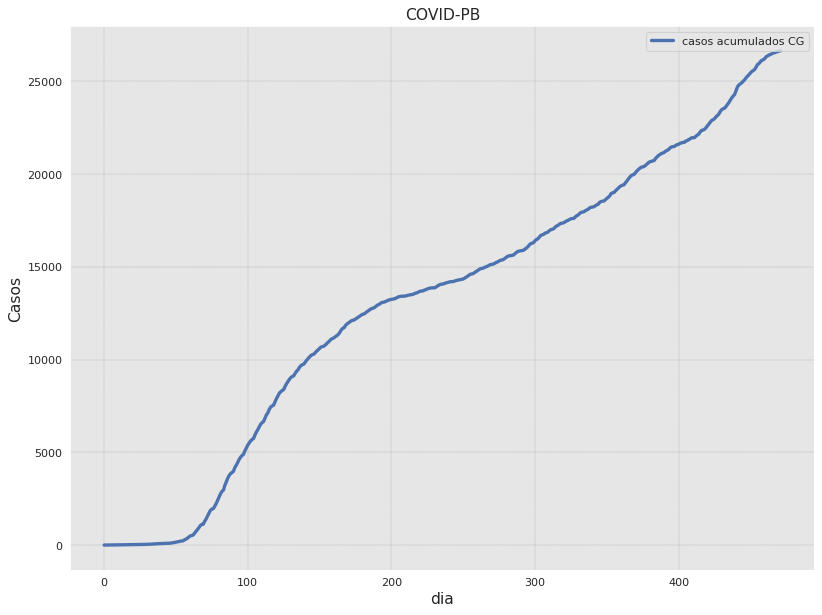

In [19]:
data = np.array(cum_casos.cum_casos.values)
data = data.reshape(-1, 1)

# escalona valores por milhares
CRdata = data/1000
CRdata  = np.ravel(CRdata)


# Visualizando o número de casos ao longo dos dias

plt.figure(1, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data, linewidth = 3)
plt.legend(['casos acumulados CG'])
plt.grid(color='k', linestyle='--', linewidth=0.1)
plt.ylabel('Casos', fontsize = 14)
plt.xlabel('dia', fontsize = 14)
plt.title('COVID-PB', fontsize = 14)

# Decomposição da série temporal


In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose


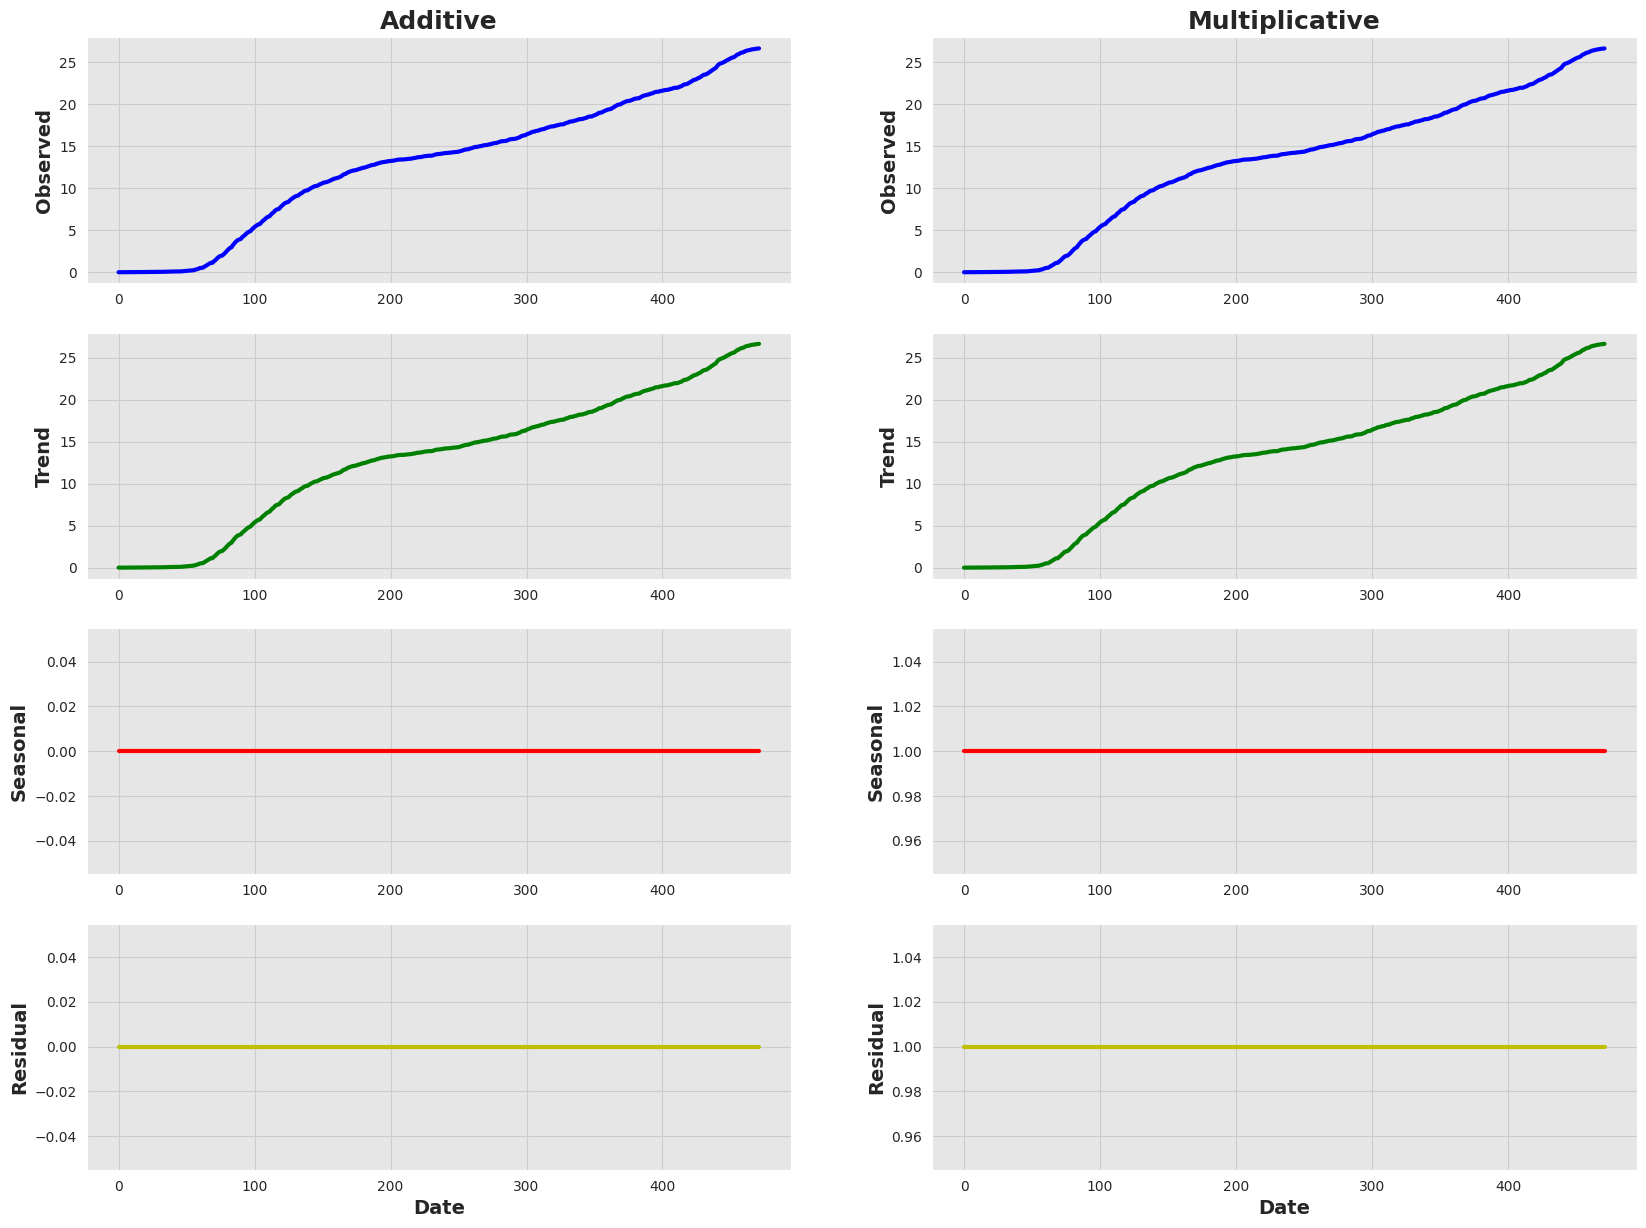

In [21]:
# Agregating in months

covid_cases = CRdata

# Decomposing using seasonal_decompose

result_add = seasonal_decompose(covid_cases, model='additive', extrapolate_trend='freq', period = 1)
result_mult = seasonal_decompose(covid_cases, model='multiplicative', extrapolate_trend='freq', period = 1)

# Plot
fig, axs = plt.subplots(figsize = (20,15), nrows = 4, ncols = 2)


axs[0][0].plot(result_add.observed, linewidth = 3, color = 'b')
axs[0][0].set_ylabel('Observed', fontsize = 14, fontweight = 'bold')
axs[0][0].set_title('Additive', fontsize = 18, fontweight = 'bold')
axs[0][0].grid(True)


axs[1][0].plot(result_add.trend,linewidth = 3, color = 'g')
axs[1][0].set_ylabel('Trend', fontsize = 14, fontweight = 'bold')
axs[1][0].grid(True)

axs[2][0].plot(result_add.seasonal,linewidth = 3, color = 'r')
axs[2][0].set_ylabel('Seasonal', fontsize = 14, fontweight = 'bold')
axs[2][0].grid(True)

axs[3][0].plot(result_add.resid,linewidth = 3, color = 'y')
axs[3][0].set_ylabel('Residual', fontsize = 14, fontweight = 'bold')
axs[3][0].set_xlabel('Date', fontsize = 14, fontweight = 'bold')
axs[3][0].grid(True)

axs[0][1].plot(result_mult.observed, linewidth = 3, color = 'b')
axs[0][1].set_ylabel('Observed', fontsize = 14, fontweight = 'bold')
axs[0][1].set_title('Multiplicative', fontsize = 18, fontweight = 'bold')
axs[0][1].grid(True)


axs[1][1].plot(result_mult.trend,linewidth = 3, color = 'g')
axs[1][1].set_ylabel('Trend', fontsize = 14, fontweight = 'bold')
axs[1][1].grid(True)

axs[2][1].plot(result_mult.seasonal,linewidth = 3, color = 'r')
axs[2][1].set_ylabel('Seasonal', fontsize = 14, fontweight = 'bold')
axs[2][1].grid(True)

axs[3][1].plot(result_mult.resid,linewidth = 3, color = 'y')
axs[3][1].set_ylabel('Residual', fontsize = 14, fontweight = 'bold')
axs[3][1].set_xlabel('Date', fontsize = 14, fontweight = 'bold')
axs[3][1].grid(True)


plt.show()

# Definindo alguns Kernels específicos e visualizando junto com o conjunto de treinamento


In [22]:
# Introduzindo um kernel para representar um ruído aleatório

kernels = []

# Definição do dataset de teste
trainL = len(CRdata) - 30

# Linha do tempo (entrada do modelo) e dados (saída do modelo)
t = np.linspace(1,len(CRdata),len(CRdata))
t = t.reshape(len(t),1)
t = np.atleast_2d(t)

# Define intervalo de treinamento
t_tr  = t[0:trainL]
t_test = t[trainL:]

CR_tr = CRdata[0:trainL]
CR_test = CRdata[trainL:]







Kernel 1: ConstantKernel()* Matern(1.0) + DotProduct() - Vindo do repositório

Podemos ver que o dot product tem um efeito muito grande no dado. A inclinação é tão grande que perdemos a escala e não conseguimos ver o efeito do matern. Apesar disso, aparentemente conseguimos capturar a tendencia do dado e por isso deve dar um bom r² no treino. Precisamos diminuir a inclinação do DotProduct.


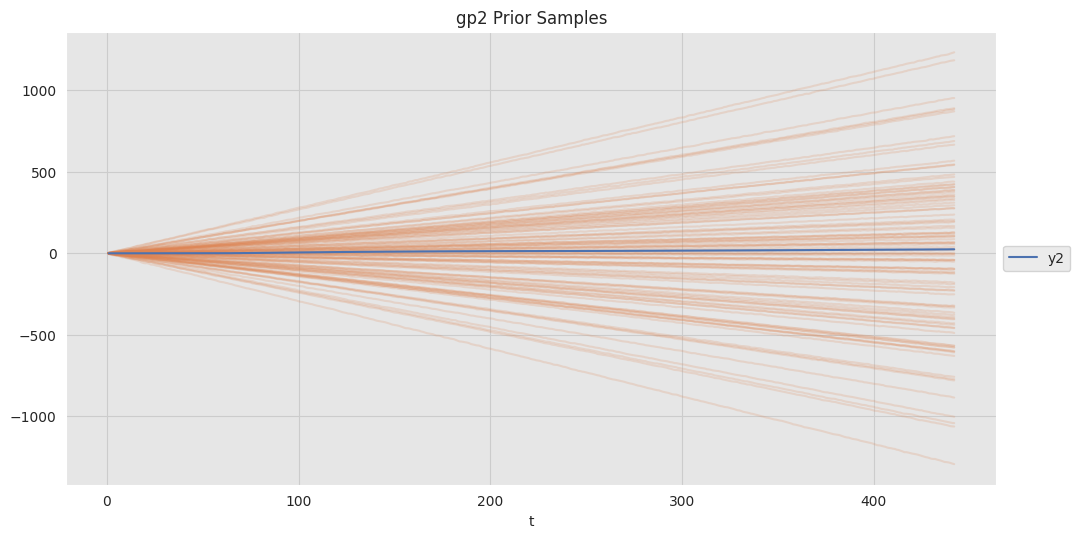

In [23]:
kernel_1 =  ConstantKernel()* Matern(1.0) + DotProduct()

kernels.extend([kernel_1])

# Visualização das funções priori desse kernel
gp1 = GaussianProcessRegressor(kernel = kernel_1)
# Prior Sampling
gp1_prior_samples = gp1.sample_y(X=t_tr, n_samples=100)

fig, ax = plt.subplots()
for i in range(100):
    sns.lineplot(x=t_tr[...,0], y = gp1_prior_samples[:, i], color=sns_c[1], alpha=0.2, ax=ax)
sns.lineplot(x=t_tr[...,0], y=CR_tr, color=sns_c[0], label='y2', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='gp2 Prior Samples', xlabel='t');

Kernel 2: ConstantKernel()* Matern(1.0)*RBF() + DotProduct().

Aqui só adicionamos um RBF multiplicando o primeiro termo. Como o Matern é parecido com o RBF, não dá pra ver mudança significativa com o que tinha antes. O dotproduct continua sobrepondo os outros efeitos


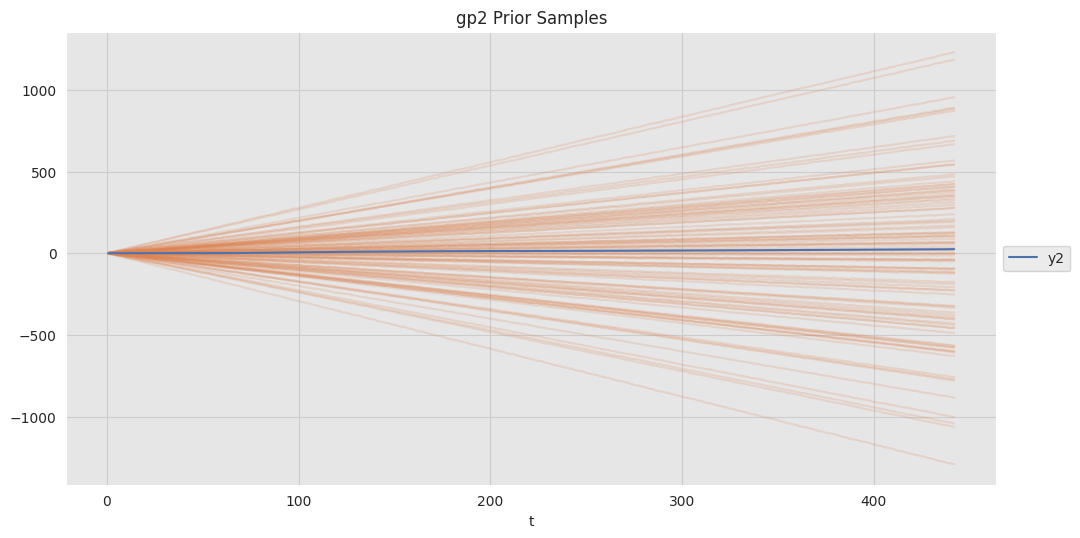

In [24]:
kernel_2 = ConstantKernel()* Matern(1.0)*RBF() + DotProduct()

kernels.extend([kernel_2])

# Visualização das funções priori desse kernel
gp2 = GaussianProcessRegressor(kernel = kernel_2)
# Prior Sampling
gp2_prior_samples = gp2.sample_y(X=t_tr, n_samples=100)

fig, ax = plt.subplots()
for i in range(100):
    sns.lineplot(x=t_tr[...,0], y = gp2_prior_samples[:, i], color=sns_c[1], alpha=0.2, ax=ax)
sns.lineplot(x=t_tr[...,0], y=CR_tr, color=sns_c[0], label='y2', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='gp2 Prior Samples', xlabel='t');



Nesse kernel, tentamos fazer o kernel anterior da referencia. Tentamos colocar uma componente periódica e uma componente de crescimento com o ConstantKernel*RBF. Eu sinceramente não entendi como isso gera uma tendencia. Esse é só um teste. Podemos ver que a escala ficou completamente fora. Não tem tendencia, é impossivel fitar o dado.


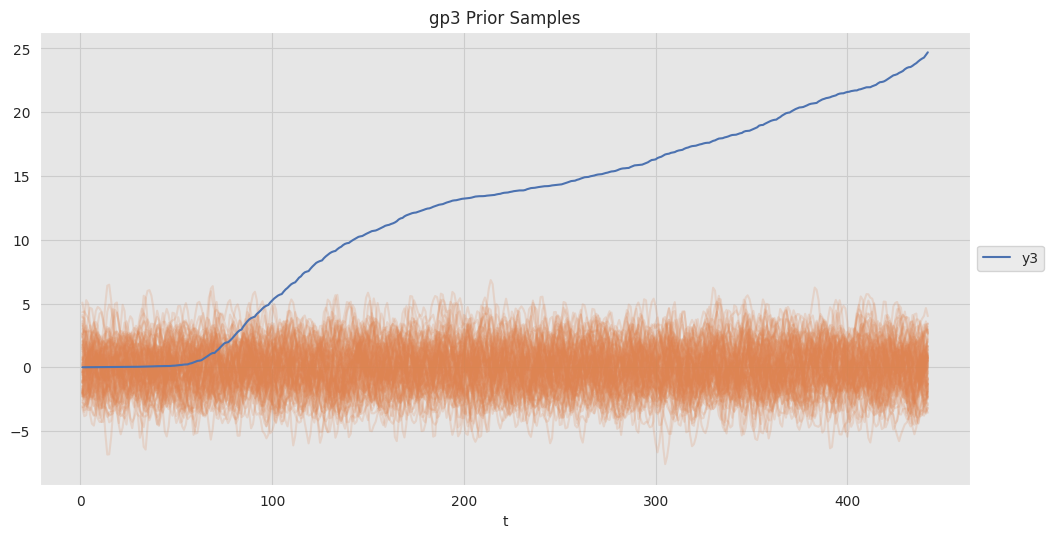

In [25]:
k0 = WhiteKernel(noise_level=0.1**2, noise_level_bounds=(0.1**2, 0.2**2))

k1 = ConstantKernel(constant_value=1) * \
  ExpSineSquared(length_scale=1.0, periodicity=20, periodicity_bounds=(18, 22))

k2 = ConstantKernel(constant_value=2, constant_value_bounds=(1e-2, 1e3)) * \
  RBF(length_scale=2, length_scale_bounds=(1, 1e3))

kernel_3  = k0 + k1 + k2


kernels.extend([kernel_3])

# Visualização das funções priori desse kernel
gp3 = GaussianProcessRegressor(kernel = kernel_3)
# Prior Sampling
gp3_prior_samples = gp3.sample_y(X=t_tr, n_samples=100)

fig, ax = plt.subplots()
for i in range(100):
    sns.lineplot(x=t_tr[...,0], y = gp3_prior_samples[:, i], color=sns_c[1], alpha=0.2, ax=ax)
sns.lineplot(x=t_tr[...,0], y=CR_tr, color=sns_c[0], label='y3', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='gp3 Prior Samples', xlabel='t');



Kernel 4: Essa é uma tentativa de capturar tendencia Utilizando o DotProduct* constantkernel com uma constante muito baixa. Também tentei fazer com que houvesse a suavidade utilizando o kernel RBF

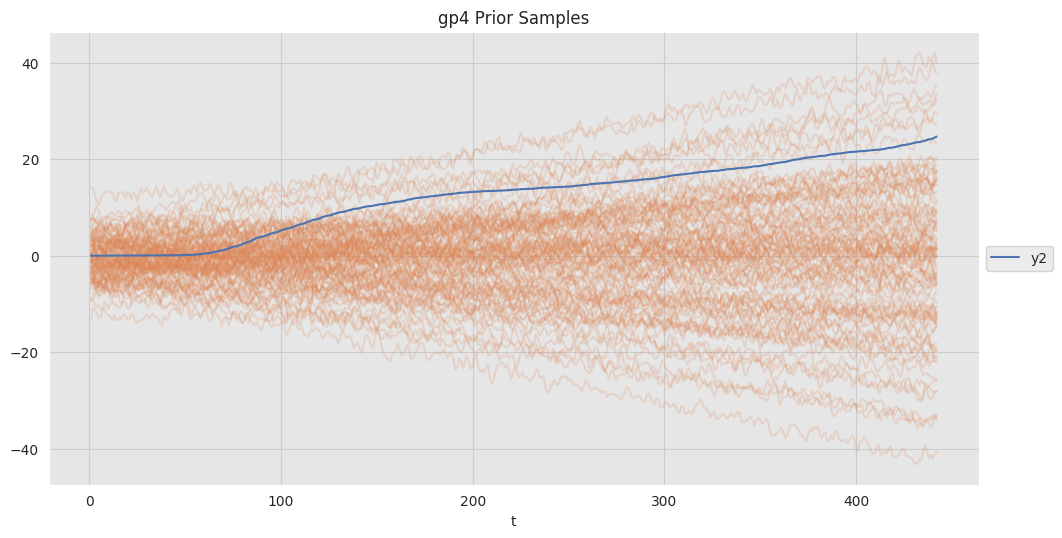

In [26]:
kernel_4 = ConstantKernel()*RBF() + DotProduct(sigma_0 = 0)*ConstantKernel(constant_value= 0.001) + ConstantKernel(constant_value = 20)

kernels.extend([kernel_4])

# Visualização das funções priori desse kernel
gp4 = GaussianProcessRegressor(kernel = kernel_4)
# Prior Sampling
gp4_prior_samples = gp4.sample_y(X=t_tr, n_samples=100)

fig, ax = plt.subplots()
for i in range(100):
    sns.lineplot(x=t_tr[...,0], y = gp4_prior_samples[:, i], color=sns_c[1], alpha=0.2, ax=ax)
sns.lineplot(x=t_tr[...,0], y=CR_tr, color=sns_c[0], label='y2', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='gp4 Prior Samples', xlabel='t');

In [41]:
gp5_prior_samples.shape

(442, 100)

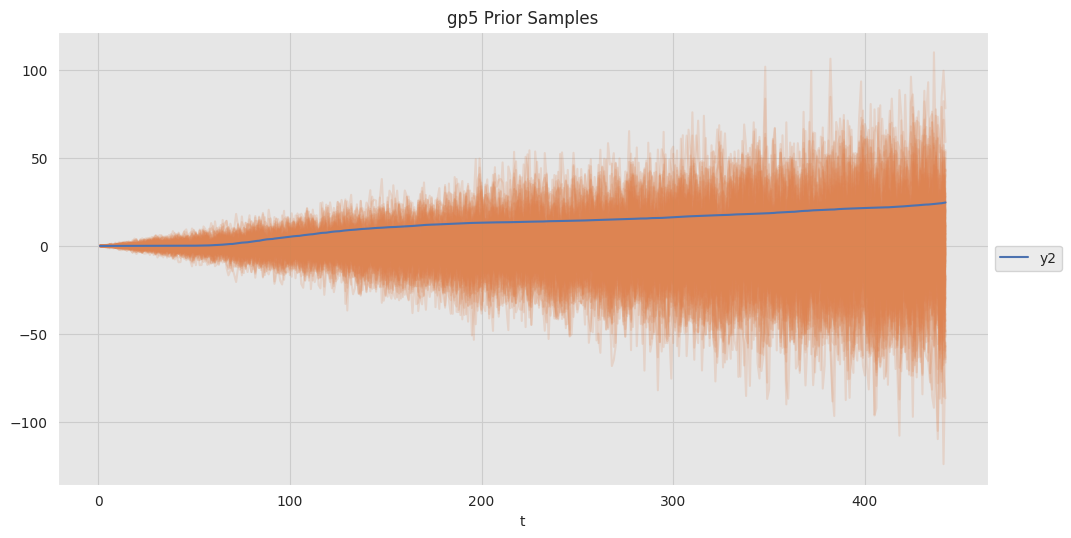

In [27]:
kernel_5 = Matern()*DotProduct(sigma_0 = 0)*ConstantKernel(constant_value= 0.005)

kernels.extend([kernel_5])

# Visualização das funções priori desse kernel
gp5 = GaussianProcessRegressor(kernel = kernel_5)
# Prior Sampling
gp5_prior_samples = gp5.sample_y(X=t_tr, n_samples=100)

fig, ax = plt.subplots()
for i in range(100):
    sns.lineplot(x=t_tr[...,0], y = gp5_prior_samples[:, i], color=sns_c[1], alpha=0.2, ax=ax)
sns.lineplot(x=t_tr[...,0], y=CR_tr, color=sns_c[0], label='y2', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='gp5 Prior Samples', xlabel='t');

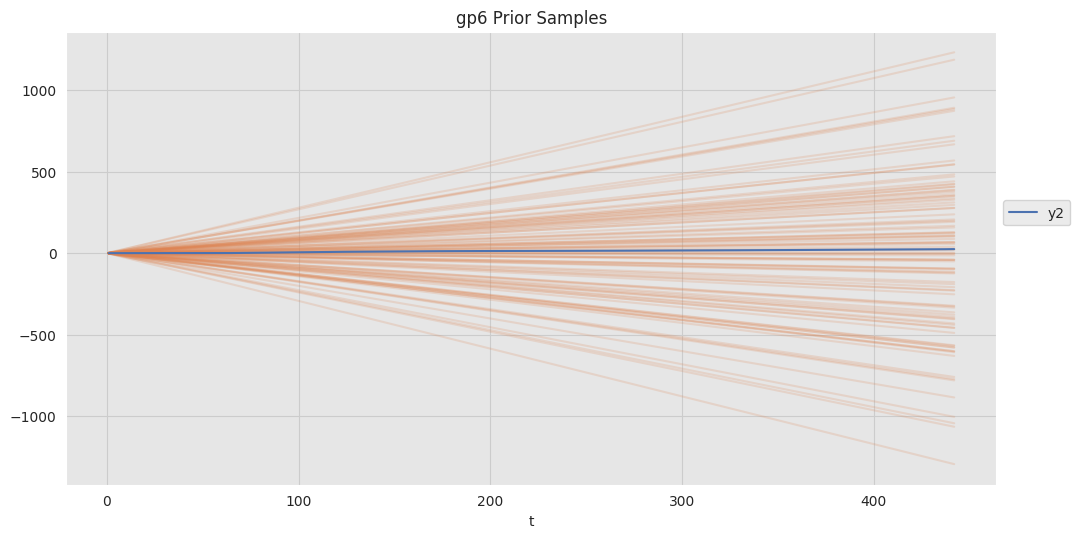

In [28]:
kernel_6 = DotProduct(sigma_0 = 0.5)

kernels.extend([kernel_6])

# Visualização das funções priori desse kernel
gp6 = GaussianProcessRegressor(kernel = kernel_6)
# Prior Sampling
gp6_prior_samples = gp6.sample_y(X=t_tr, n_samples=100)

fig, ax = plt.subplots()
for i in range(100):
    sns.lineplot(x=t_tr[...,0], y = gp6_prior_samples[:, i], color=sns_c[1], alpha=0.2, ax=ax)
sns.lineplot(x=t_tr[...,0], y=CR_tr, color=sns_c[0], label='y2', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.6))
ax.set(title='gp6 Prior Samples', xlabel='t');

In [29]:
# Agora vamos fazer um objeto de pipeline com o time series split pra começar a avaliar os kernels
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
tscv = TimeSeriesSplit(n_splits=5)
model = GaussianProcessRegressor()
param_search = {'model__kernel': kernels, 'model__alpha': [1e-2, 1e-3]}

new_model = Pipeline([('scaler', MinMaxScaler()), ('model', model)])

scoring = {'R2': 'r2', 'mse': 'neg_root_mean_squared_error'}


gsearch = GridSearchCV(estimator=new_model, cv=tscv, scoring=scoring,
                        param_grid=param_search, refit = False)

In [30]:
gsearch.fit(X,y)


6

/home/andre/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))
/home/andre/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))
/home/andre/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))
/home/andre/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))
/home/andre/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))
/home/andre/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('model', GaussianProcessRegressor())]),
             param_grid={'model__alpha': [0.01, 0.001],
                         'model__kernel': [1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1),
                                           1**2 * Matern(length_scale=1, nu=1.5) * RBF(length_scale=1) + DotProduct(sigma_0=1),
                                           WhiteKernel(noise_level=0.01) + 1**2 * ExpSineSquared(length_scale=1, periodicity=20) + 1.41**2 * RBF(length_scale=2),
                                           1**2 * RBF(length_scale=1) + DotProduct(sigma_0=0) * 0.0316**2 + 4.47**2,
                                           Matern(length_scale=1, nu=1.5) * DotProduct(sigma_0=0) * 0.0707**2,
                                           DotProduct(sigma_0=0.5)]},
             r

In [32]:
gsearch.cv_results_

{'mean_fit_time': array([0.39797096, 0.33266325, 0.4594789 , 0.69593511, 0.3317606 ,
        0.08015599, 0.61030526, 0.81576409, 0.6555213 , 0.68401089,
        0.3206254 , 0.08479557]),
 'std_fit_time': array([0.2589637 , 0.17745484, 0.31208012, 0.48837343, 0.27762431,
        0.04102307, 0.31496909, 0.68133157, 0.34370501, 0.51136385,
        0.19331863, 0.05624867]),
 'mean_score_time': array([0.00806251, 0.00870175, 0.00931234, 0.00845771, 0.01014338,
        0.00596871, 0.01542101, 0.00627575, 0.00620198, 0.01039948,
        0.00897217, 0.00704498]),
 'std_score_time': array([0.00350025, 0.0037389 , 0.00385063, 0.00355842, 0.00540179,
        0.00772222, 0.00841427, 0.0045573 , 0.0041431 , 0.00552586,
        0.00663164, 0.00782121]),
 'param_model__alpha': masked_array(data=[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.001, 0.001,
                    0.001, 0.001, 0.001, 0.001],
              mask=[False, False, False, False, False, False, False, False,
                    False, False,

In [33]:
from prettytable import PrettyTable
def summaryResults(gsearch, modelname, granularity, ranking = True):
    # print(gsearch.cv_results_.keys())
    results = pd.DataFrame(gsearch.cv_results_)
    results.sort_values(by='rank_test_R2', inplace=True)
    results = results.reset_index(drop=True)
    
    t = PrettyTable()
    t.field_names = ["Item","Valor"]
    t.add_row(["Maior R2",np.max(results['mean_test_R2'])])
    t.add_row(["Menor R2",np.min(results['mean_test_R2'])])
    t.add_row(["Std R2", np.std(results['mean_test_R2'])])
    t.add_row(["Melhor MSE:", np.max(results['mean_test_mse'])])
    t.add_row(["Quantidade de modelos: ",len(results)])
    print(t.get_string(title="Summary for " + modelname + " @ " + granularity))
    
    t = PrettyTable()
    t.field_names = ["Ranking", "Parametros","R2-mean","R2-std", "MSE-mean", "MSE-std"]
    names = ['params', 'mean_test_R2', 'std_test_R2','mean_test_mse', 'std_test_mse' ]
    t._max_width = {"Parametros":1}
    
    if not ranking:
        end = 1
    else:
        end = 3
    
    for i in range(0,end):
        lista = [i + 1]
        for n in names:
            lista.append(results.loc[i,n])
        t.add_row(lista)

    print(t.get_string(title="Top-3 " + modelname + " for " + granularity))
    
    t = PrettyTable()
    fields = []
    values = []
    for i in range(0,5):
        fname = 'split' + str(i)+'_test_R2'
        fields.append(fname)
        values.append(results.loc[0,fname])
        
    t.field_names = fields
    t.add_row(values)
    print(t)

In [34]:
summaryResults(gsearch, 'gpr', 'cg')

+-----------------------------------------------+
|              Summary for gpr @ cg             |
+-------------------------+---------------------+
|           Item          |        Valor        |
+-------------------------+---------------------+
|         Maior R2        |  0.2647061548668989 |
|         Menor R2        | -194.66321831439984 |
|          Std R2         |  63.98415687949577  |
|       Melhor MSE:       | -1.0854197491986455 |
| Quantidade de modelos:  |          12         |
+-------------------------+---------------------+
+--------------------------------------------------------------------------------------------------------------+
|                                               Top-3 gpr for cg                                               |
+---------+------------+---------------------+---------------------+---------------------+---------------------+
| Ranking | Parametros |       R2-mean       |        R2-std       |       MSE-mean      |       MSE-std       

In [35]:
import matplotlib
from matplotlib.patches import Patch
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
def plot_cv_indices(cv, n_splits, X, y, date_col = None):
    """Create a sample plot for indices of a cross-validation object."""
    
    fig, ax = plt.subplots(1, 1, figsize = (11, 7))
    
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=10, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)


    # Formatting
    yticklabels = list(range(n_splits))
    
    if date_col is not None:
        tick_locations  = ax.get_xticks()
        tick_dates = [" "] + date_col.iloc[list(tick_locations[1:-1])].astype(str).tolist() + [" "]

        tick_locations_str = [str(int(i)) for i in tick_locations]
        new_labels = ['\n\n'.join(x) for x in zip(list(tick_locations_str), tick_dates) ]
        ax.set_xticks(tick_locations)
        ax.set_xticklabels(new_labels)
    
    # ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
    #        xlabel='Sample index', ylabel="CV iteration",
    #        ylim=[n_splits+0.2, -.2])
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(1.02, .8))
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)

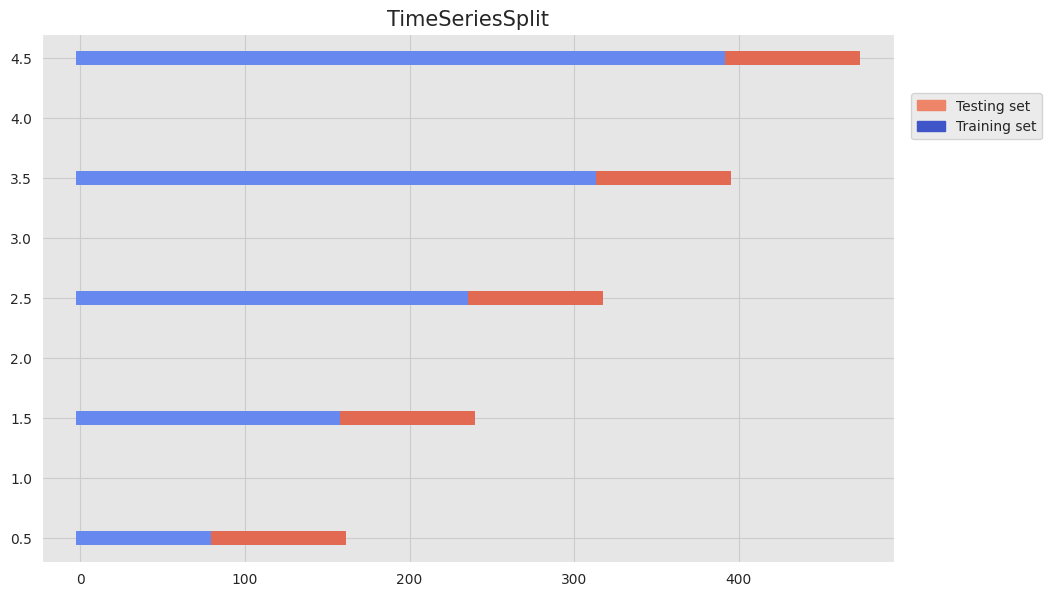

In [36]:
plot_cv_indices(tscv,5,t, CRdata)


# Vamos agora tentar a abordagem do método carrossel de Kernels

In [37]:
kernel = []

## Constant -- Não estacionário
kernel.extend([ConstantKernel(constant_value=x) for x in range(1,5)])
## ExpSineSquared -- Não estacionário
kernel.extend([ExpSineSquared(length_scale=x, periodicity=y) for (x,y) in zip(range(10,26),range(10,26))])
## RBF -- Estacionário
kernel.extend([RBF(l) for l in np.logspace(-1, 1, 2)])
## Dot Product -- Não estacionário
kernel.extend([DotProduct(sigma_0) for sigma_0 in range(1,10)])
## Matern -- Estacionário
kernel.extend([Matern(length_scale=l, nu=1.5) for l in np.linspace(1,30,30)])

In [38]:
combinations = []
for k in kernel:
    for j in [item for item in kernel if item != k]:
        combinations += [k+j, k*j]

combinations.extend(kernel)
        
print("Resultado do Carrossel: ",len(combinations))

Resultado do Carrossel:  7381


In [39]:
tscv = TimeSeriesSplit(n_splits=5)
model = GaussianProcessRegressor()
param_search = {'model__kernel': kernel, 'model__alpha': [1e-2, 1e-3]}

new_model = Pipeline([('scaler', MinMaxScaler()), ('model', model)])

scoring = {'R2': 'r2', 'mse': 'neg_root_mean_squared_error'}


gsearch = GridSearchCV(estimator=new_model, cv=tscv, scoring=scoring,
                        param_grid=param_search, refit = False)
gsearch.fit(t,CRdata)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('model', GaussianProcessRegressor())]),
             param_grid={'model__alpha': [0.01, 0.001],
                         'model__kernel': [1**2, 1.41**2, 1.73**2, 2**2,
                                           ExpSineSquared(length_scale=10, periodicity=10),
                                           ExpSineSquared(length_scale=11, periodicity=1...
                                           ExpSineSquared(length_scale=24, periodicity=24),
                                           ExpSineSquared(length_scale=25, periodicity=25),
                                           RBF(length_scale=0.1),
                                           RBF(length_scale=10),
                                           DotProduct(sigma_0=1),
                                           DotProduct(sigma_0=2),
    

In [40]:
summaryResults(gsearch, 'gpr', 'cg')

+-----------------------------------------------+
|              Summary for gpr @ cg             |
+-------------------------+---------------------+
|           Item          |        Valor        |
+-------------------------+---------------------+
|         Maior R2        |  -4.639417813550144 |
|         Menor R2        | -194.66321831439984 |
|          Std R2         |  73.80751571444351  |
|       Melhor MSE:       | -2.7941558106701687 |
| Quantidade de modelos:  |         122         |
+-------------------------+---------------------+
+-----------------------------------------------------------------------------------------------------------+
|                                              Top-3 gpr for cg                                             |
+---------+------------+---------------------+-------------------+---------------------+--------------------+
| Ranking | Parametros |       R2-mean       |       R2-std      |       MSE-mean      |      MSE-std       |
+---------